In [1]:
%matplotlib inline
# globals
import matplotlib as mpl
from customize_matplotlib import clean_axis, set_fonts
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from scipy.stats import tsem
set_fonts(mpl, 'paper')

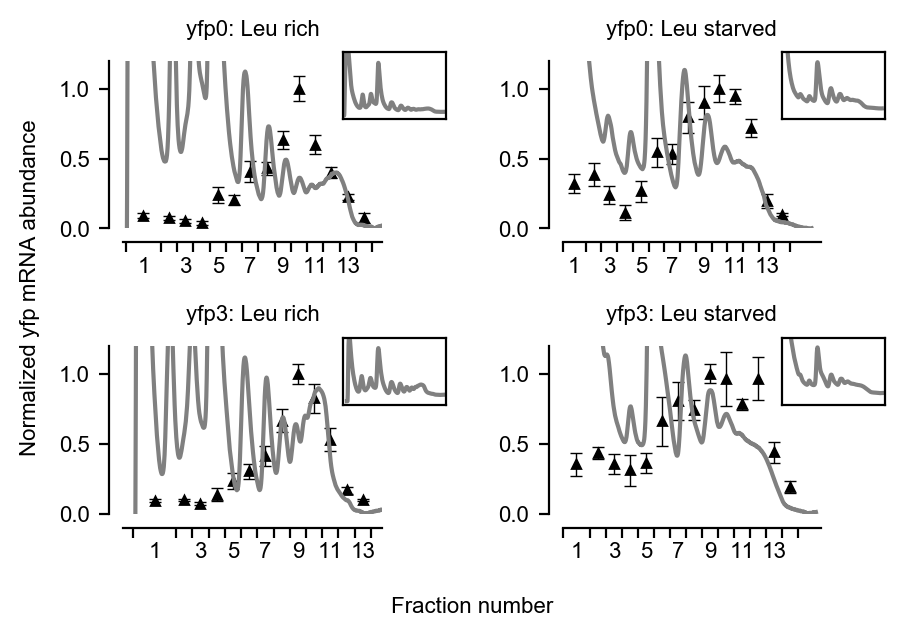

In [4]:
# Get polysome profile data
# get list of all raw csv files
parentdir = '../rawdata/sucrosegradients/'
listoffiles = [
    parentdir + File for File in os.listdir(parentdir)
    if File.startswith('20160617')
]
# sort alphabetically
listoffiles = sorted(listoffiles, key=lambda File: File.split('_')[-1])
samplenames = pd.read_table(parentdir + 'samplenames.tsv', index_col=0)
polysomedata = dict()
for File in listoffiles:
    samplename = samplenames.ix[int(File.split('_')[-1][-5])]['samplename']
    polysomedata[samplename] = pd.read_table(
        File, skiprows=32, sep=',', skipinitialspace=True)

# Align x, normalize y to monosome peak for all polysome profiles
ynorm = dict()
xnorm = dict()
disome = dict()
ymin = dict()
for sample in polysomedata:
    monosomeSubset = polysomedata[sample]['Distance(mm)'] > 20
    disomeSubset = polysomedata[sample]['Distance(mm)'] > 33
    monosomeSubsetData = polysomedata[sample][monosomeSubset]
    disomeSubsetData = polysomedata[sample][disomeSubset]
    ynorm[sample] = np.max(monosomeSubsetData['Absorbance'])
    maxyindex = np.argmax(monosomeSubsetData['Absorbance'])
    xnorm[sample] = monosomeSubsetData.ix[maxyindex]['Distance(mm)']
    disome[sample] = np.max(disomeSubsetData['Absorbance'])
    ymin[sample] = np.min(disomeSubsetData['Absorbance'])

avgxnorm = np.mean(list(xnorm.values()))
xnorm = {key: (value - avgxnorm) for key, value in xnorm.items()}

# Get qPCR data
parentdir = '../rawdata/qpcr/polysome_fig1c/'
qpcrfiles = [parentdir + File for File in os.listdir(parentdir)]
qpcrdata = []
for File in qpcrfiles:
    qpcrdata.append(pd.read_table(File)[['ct', 'samplename']])
qpcrdata = pd.concat(qpcrdata)
qpcrdata = qpcrdata[qpcrdata['samplename'].apply(lambda x: x.find('-RT') == -1)]
qpcrdata['ct'] = qpcrdata['ct'].apply(float)

# Normalize by Fluc
averagedqpcrdata = qpcrdata.groupby('samplename')['ct'].agg([np.mean, tsem])
averagedqpcrdata['normmean'] = np.nan
averagedqpcrdata['normtsem'] = np.nan
for row in averagedqpcrdata.iterrows():
    normsample = row[0].replace('leu1214primer', 'flucprimer')
    averagedqpcrdata.ix[row[0]]['normmean'] = row[1][
        'mean'] - averagedqpcrdata.ix[normsample]['mean']
    averagedqpcrdata.ix[row[0]]['normtsem'] = row[1][
        'tsem'] + averagedqpcrdata.ix[normsample]['tsem']
averagedqpcrdata = averagedqpcrdata.select(lambda x: x.find('fluc') == -1)

# Plot Fig. 1C
fig = plt.figure()
fig.set_size_inches([4.5, 3])  # width, height
# common axis below used for a shared x and y label across panels
commonaxis = plt.axes(frameon=False)
commonaxis.set_xticks([])
commonaxis.set_yticks([])
commonaxis.yaxis.labelpad = 30  # move the labels a bit away from panels
commonaxis.xaxis.labelpad = 30  # move the labels a bit away from panels
commonaxis.set(xlabel='Fraction number',
               ylabel='Normalized yfp mRNA abundance')
samplelabels = {
    'yfp0_rich': 'yfp0: Leu rich',
    'yfp0_starve': 'yfp0: Leu starved',
    'cta1314_rich': 'yfp3: Leu rich',
    'cta1314_starve': 'yfp3: Leu starved'
}
samplenumber = 0
for polysomesample in [
        'yfp0_rich', 'yfp0_starve', 'cta1314_rich', 'cta1314_starve'
]:
    # this subtracts a constant values from X-axis to align all monosome
    # peaks
    xadjust = xnorm[polysomesample]
    samplenumber += 1
    ax1 = fig.add_subplot(2, 2, samplenumber)
    ax2 = ax1.twinx()
    ax2_inset = inset_axes(
        ax2,
        width="40%",  # width = 10% of parent_bbox width
        height="40%",  # height : 50%
        loc=1,
        bbox_to_anchor=(0.25, 0.05, 1, 1),
        bbox_transform=ax2.transAxes,
        borderpad=0, )
    fractionchanges = polysomedata[polysomesample].dropna(
        subset=['Fraction Number'])
    previouslocation = 0
    fractionpositions = []
    linepositions = [previouslocation]
    for xlocation, fraction in zip(
            fractionchanges['Distance(mm)'] - xnorm[polysomesample],
            fractionchanges['Fraction Number']):
        if fraction == '1':  # this fraction was combined with fraction 2
            continue
        textposition = xlocation - (xlocation - previouslocation) / 2
        fractionpositions.append(textposition)
        linepositions.append(xlocation)
        previouslocation = xlocation
    subsetdata = averagedqpcrdata.select(
        lambda x: x.startswith(polysomesample))
    subsetdata['err'] = map(
        lambda x: np.log(2) * x[1]['normtsem'] * 2**(-x[1]['normmean']),
        subsetdata.iterrows())
    subsetdata['mean'] = map(lambda x: 2**(-x[1]['normmean']),
                             subsetdata.iterrows())
    norm = max(subsetdata['mean'])
    subsetdata = subsetdata / norm
    x = fractionpositions[:len(subsetdata)] - xadjust
    linex = linepositions[:len(subsetdata) + 1] - xadjust
    ax2.set_ylim(
        bottom=ymin[polysomesample] / ynorm[polysomesample],
        top=1.05 * (disome[polysomesample] / ynorm[polysomesample]))
    ax2x = polysomedata[polysomesample]['Distance(mm)'] - xadjust
    ax2y = polysomedata[polysomesample]['Absorbance'] / ynorm[polysomesample]
    ax2.plot(ax2x, ax2y, color='0.5', label='$A_{260}$', zorder=1)
    ax2_inset.plot(
        polysomedata[polysomesample]['Distance(mm)'] - xnorm[polysomesample],
        polysomedata[polysomesample]['Absorbance'] / ynorm[polysomesample],
        color='0.5')
    ax1.errorbar(
        x,
        subsetdata['mean'],
        subsetdata['err'],
        linestyle='None',
        marker='^',
        markersize=3,
        color='black',
        elinewidth=0.5,
        capthick=0.5,
        capsize=2,
        zorder=10)
    [
        ax1.text(
            (linex[n + 1] + linex[n]) / 2,
            -0.2,
            str(n + 1),
            zorder=1,
            fontsize=8,
            ha='center',
            va='top') for n in range(0, len(linex) - 1, 2)
    ]
    # customize axis display
    ax1.set_title(samplelabels[polysomesample], y=1.05)
    clean_axis(ax1)
    ax2.axis('off')

    ax1.set_xlim(left=0, right=80)
    ax1.set_xticks(linex)
    ax1.set_xticklabels([])
    ax1.set_ylim(bottom=0, top=1.2)
    ax2_inset.yaxis.set(ticks_position='none')
    ax2_inset.xaxis.set(ticks_position='none')
    ax2_inset.set_xlim(left=0, right=80)
    ax2_inset.set_ylim(top=1.2)
    ax2_inset.set_xticks([])
    ax2_inset.set_yticks([])

# ax2.legend(bbox_to_anchor=[1.2, -0.5])
fig.subplots_adjust(wspace=0.7, hspace=0.7)
fig.savefig('../figures/fig1c.svg')